In [3]:
# hologram parameters #########################
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat
from scipy.ndimage import shift
hologramZ = 0
lambda_ = wlen = 530e-09 #530e-9, 470e-9] #[550e-09,550e-09,550e-09] #[640e-9, 530e-9, 470e-9]
sampleDis_object = 1e-05  #distance between points of object
samplingDis_hologram = 1e-05
z = rec_dist = depth = 0.02
zero_pad = 0
# 0.02
m = 512
hologramHeight = hologramWidth  = m * 1e-5 # 256e-5 #image size affects dictionay sizes
PointDist = sampleDis_object
dim = np.round(hologramHeight / samplingDis_hologram)
m = n = int(dim)
Dir = "../matfile"


In [195]:
# !pip install cupy-cuda11x
# import cupy as cp

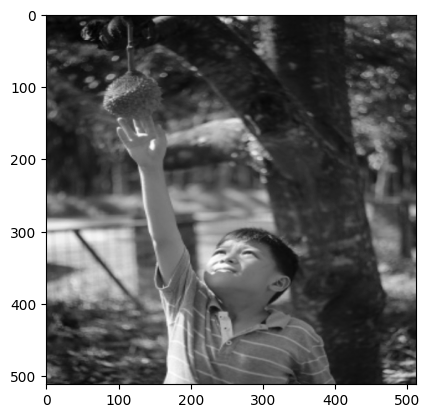

[[0.0004306  0.00040766 0.00037185 ... 0.0015294  0.00161891 0.00167628]
 [0.00048227 0.00045546 0.00041365 ... 0.00133877 0.00136814 0.00138697]
 [0.0005075  0.00048401 0.00044737 ... 0.00113355 0.00112544 0.00112024]
 ...
 [0.00078864 0.00079052 0.00079346 ... 0.00096467 0.00091348 0.00088067]
 [0.0009667  0.00094877 0.0009208  ... 0.00084561 0.00083344 0.00082564]
 [0.00124567 0.00132026 0.00143662 ... 0.00075494 0.00077284 0.00078431]]


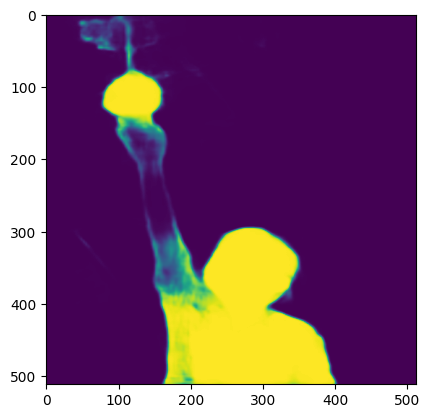

(<matplotlib.image.AxesImage at 0x7f33040c1c30>, None)

In [4]:
# Load the image #########################
I = cv2.imread("./pairs_of_saliency//0945.jpg")
#I = cv2.imread("grid.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I = I.astype('float32') / 255.0
m = n = 512
I = cv2.resize(I,[m,n])
I = I/255

#I = I * np.exp(1j * np.random.rand(m, n) * 2 * np.pi)
plt.imshow(np.real(I),cmap='gray') , plt.show()
print(np.real(I))
# cv2.imwrite('resized_grid.png', I)
M = N  = m
#plt.imshow(I,cmap="gray"), plt.show()
img = I
start = 0
end = 0
################################### saliency #############################
saliencymap = cv2.imread("./pairs_of_saliency//0945_sal_fuse.png")
saliencymap = cv2.cvtColor(saliencymap, cv2.COLOR_BGR2GRAY)
saliencymap = cv2.resize(saliencymap,[m,n])
sal = saliencymap/255
plt.imshow(sal),plt.show()

In [5]:
# Hologram generation function ###########
import numpy as np
import math
import random
import matplotlib.pyplot as plt

def digitalHologramGeneration_gray(lambda_=None, hologramHeight=None, hologramWidth=None, hologramZ=None,
                              samplingDistance=None, points3D=None):

    hologramSamplesX = np.floor(hologramWidth / samplingDistance)
    hologramSamplesY = np.floor(hologramHeight / samplingDistance)

    hologramCornerX = - (hologramSamplesX - 1) * samplingDistance / 2
    hologramCornerY = - (hologramSamplesY - 1) * samplingDistance / 2
    # Initial amplitude
    a = 1
    k = np.divide(2 * math.pi , lambda_)

    points = points3D

    x = np.arange(0, hologramSamplesX ) * samplingDistance + hologramCornerX
    y = np.arange(0, hologramSamplesY ) * samplingDistance + hologramCornerY

    xx, yy = np.meshgrid(x, y)
    objectWave = np.zeros([int(hologramSamplesY), int(hologramSamplesX)], dtype="complex_")
    
    # Superposition of all the spherical waves
    for source in np.arange(0, points.shape[0]):
        # For backpropagation, flip the sign of the imaginary unit
        if (points[source, 2] > hologramZ):

            ii = -1j
        else:
            ii = 1j
        # Window function
        h = np.ones([int(hologramSamplesX), int(hologramSamplesY)])
        # Limiting the contribution area
        p = samplingDistance

        Rmax = np.abs(points[source, 2] * np.tan(np.arcsin (np.divide(lambda_ , (2 * p)) ) ) )

        # the smaller the depth is, the smaller the RMAX, it is very tiney
        distance = np.sqrt((xx - points[source, 0]) ** 2 + (yy - points[source, 1]) ** 2)
        h[distance >= Rmax] = 0

        r = np.sqrt((xx - points[source, 0]) ** 2 + (yy - points[source, 1]) ** 2 + (hologramZ - points[source, 2]) ** 2)

        randomphase = 0 #random.random()
        objectWave= objectWave + np.multiply(np.multiply(a, np.exp(ii *( k * r + randomphase *2*np.pi))) /r, h)

    hologram_output = objectWave

    return hologram_output

In [6]:
#points coordinates ####################
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
def Complete_dictionary_gray(Dir,lambda_,hologramHeight,hologramWidth,hologramZ,sampldis1, sampldis2):

    sampleDis_object = sampldis2
    samplingDis_hologram = sampldis1
    #     |
    #     |
    # - - * - -
    #     |
    #     |
    hol_sizeX = np.int16(hologramWidth/samplingDis_hologram)
    hol_sizeY = np.int16(hologramHeight / samplingDis_hologram)

    idx = 0
    myDict1 = {}
    myDict2 = {}
    myDict4 = {}
    myDict8 = {}

    startof_depth = 0.02
    endof_depth = 0.022
    stepof_depth = 0.02
    rounddigit = 3
    
#1x1---------------------------------------------------------------------------
    for depth in list(np.arange(startof_depth, endof_depth, stepof_depth)):

        depth = round(depth, rounddigit)
        points = np.array( [[0,0,-depth]] )
        points = np.round(points / sampleDis_object) * sampleDis_object

        hol1 = digitalHologramGeneration_gray(lambda_,hologramHeight,hologramWidth,hologramZ,samplingDis_hologram,points)
      #  plt.imshow(np.real(hol1)),plt.title(str(depth)),plt.show()
        myDict1.update({str(depth): hol1})
       # recons_hol_8LLL = rec_asm(hol1, samplingDis_hologram, lambda_, depth, zero_pad=1)
       # plt.imshow(recons_hol_8LLL)
    points = []
    print('1x1 is made')
#2x2 --------------------------------------------------------------------------
    for depth in list(np.arange(startof_depth, endof_depth, stepof_depth)):
        depth = round(depth, rounddigit)
        points_blocks = np.array([], dtype=np.float16).reshape(0, 3)
        
        for i in range(-1, 1):
            for j in range(-1, 1):

                m = 0 + (j * sampleDis_object) #points in the origin
                n = 0 + (i * sampleDis_object)
                point = (np.array([m, n, -depth]))
                points_blocks = np.vstack([point, points_blocks])

        points_blocks = np.round(points_blocks / sampleDis_object) * sampleDis_object
        
        hol1 = digitalHologramGeneration_gray(lambda_, hologramHeight, hologramWidth, hologramZ, samplingDis_hologram,points_blocks)
        #plt.imshow(np.real(hol1))
        #plt.show()
        myDict2.update({str(depth): hol1})
        points_blocks = np.array([], dtype=np.float16).reshape(0, 3)
        points = []
    print('2x2 is made')
#np.arange(0, 0.005, 0.001)) +
#4x4 --------------------------------------------------------------------------
    for depth in list(np.arange(startof_depth, endof_depth, stepof_depth)):

        depth = round(depth, rounddigit)
        points = []
        points_blocks = np.array([], dtype=np.float16).reshape(0, 3)

        for i in range(-2,2):
            for j in range(-2,2):
                m = 0 + (j * sampleDis_object)
                n = 0 + (i * sampleDis_object)
                point = (np.array([m, n, -depth]))
                points_blocks = np.vstack([point, points_blocks])

        points_blocks = np.round(points_blocks / sampleDis_object) * sampleDis_object

        hol1 = digitalHologramGeneration_gray(lambda_,hologramHeight,hologramWidth,hologramZ,samplingDis_hologram,points_blocks)
        #plt.imshow(np.real(hol1))
        #plt.show()
        myDict4.update({str(depth): hol1})
        points_blocks = np.array([], dtype=np.float16).reshape(0, 3)
        points = []
    print('4x4 is made')
#8x8 --------------------------------------------------------------------------
    for depth in list(np.arange(startof_depth, endof_depth, stepof_depth)):
        depth = round(depth, rounddigit)
        points = []
        points_blocks = np.array([], dtype=np.float16).reshape(0, 3)

        for i in range(-4, 4):
            for j in range(-4, 4):
                m = 0 + (j * sampleDis_object)
                n = 0 + (i * sampleDis_object)
                point = (np.array([m, n, -depth]))
                points_blocks = np.vstack([point, points_blocks])
        points_blocks = np.round(points_blocks / sampleDis_object) * sampleDis_object
        hol1 = digitalHologramGeneration_gray(lambda_, hologramHeight, hologramWidth, hologramZ, samplingDis_hologram,
                                              points_blocks)
        # plt.imshow(np.real(hol1))
        # plt.show()
        myDict8.update({str(depth): hol1})
        points_blocks = np.array([], dtype=np.float16).reshape(0, 3)
        points = []
    print('8x8 is made')

    return myDict1,myDict2,myDict4,myDict8



myDict1, myDict2, myDict4, myDict8 = Complete_dictionary_gray(Dir,lambda_, hologramHeight, hologramWidth, hologramZ, samplingDis_hologram,sampleDis_object)
myDict1_, myDict2_, myDict4_, myDict8_ = Complete_dictionary_gray(Dir,lambda_, hologramHeight, hologramWidth, hologramZ, samplingDis_hologram,sampleDis_object)

# savemat("hol_1x1.mat", myDict1)
# savemat("hol_2x2.mat", myDict2)
# savemat("hol_4x4.mat", myDict4)
# savemat("hol_8x8.mat", myDict8)
# #img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# myDict1 = loadmat(Dir + "/myDict1.mat")
# myDict2 = loadmat(Dir + "/myDict2.mat")
# myDict4 = loadmat(Dir + "/myDict4.mat")
# myDict8 = loadmat(Dir + "/myDict8.mat")

1x1 is made
2x2 is made
4x4 is made
8x8 is made
1x1 is made
2x2 is made
4x4 is made
8x8 is made


In [7]:
#rec_asm_gray reconstruction function ##################
import numpy as np
import math
#from numba import jit
import matplotlib.pyplot as plt
#from cmath import sqrt,exp

def rec_asm_gray(hol = None,pitch = None,wlen = None,rec_dist = None,zero_pad =1):

    rec_dist = np.abs(rec_dist)

    [Ny, Nx] = np.shape(hol)

    dx = 1 / (Nx * pitch)
    hol = hol/np.max(np.abs(hol))


    if zero_pad == 1:
        recons = np.zeros([Nx * 2, Ny * 2], dtype="complex_")
        recons[np.int(Ny / 2): np.int(Ny / 2) + Ny, np.int(Nx / 2): np.int(Nx / 2) + Nx] = hol
        Ny = Ny * 2
        Nx = Nx * 2
    else:
        recons = np.zeros([Nx , Ny], dtype=np.complex128)
        recons = (hol)

    dx = 1/(Nx*pitch)
    fx = np.arange(-1 / (2 * pitch), 1/(2 * pitch), dx, dtype = np.double)
    fy = np.arange(-1 / (2 * pitch), 1 / (2 * pitch) , dx, dtype = np.double)


    X, Y = np.meshgrid(fx,fy)

    #F = np.zeros(np.shape(hol),dtype=np.single)
    F = np.fft.fftshift((X) ** 2 +  Y ** 2)
    F = np.ceil(F * pitch) / pitch

    #temp = (1 / wlen) ** 2 - F
    temp = (1 / wlen) ** 2 - F
   # H = np.exp(-2j * math.pi * np.sqrt( temp) * rec_dist)
    H = np.exp(-2j * math.pi * np.sqrt(temp) * rec_dist)

    #H = np.exp(-2j * math.pi * np.sqrt( np.maximum(full_zero, temp)) * rec_dist)

    H[H == 1] = 0
    #plt.imshow(np.real(H)), plt.show()

    #plt.imshow(np.real(recons)), plt.show()

    recons = np.fft.fft2(recons)
    recons = np.multiply(recons,H)
    recons = np.fft.ifft2(recons)

   # plt.imshow(np.real(recons)), plt.show()

    if zero_pad == 1:
        Ny = np.int(Ny / 2)
        Nx = np.int(Nx / 2)

        recons = np.abs(recons[np.int(Ny / 2) :np.int(Ny / 2) + Ny, np.int(Nx / 2) : np.int(Nx / 2) + Nx]) #np.abs

    else:
        recons = np.abs(recons)

    return recons

###########################################
# from scipy.io import savemat,loadmat
# hologramZ = 0
# lambda_ = wlen = [550e-09,550e-09,550e-09] #[640e-9, 532e-9, 473e-9 ] # #
# sampleDis_object = 1e-05  #distance between points of object
# #since lambda/2*sampling_hologram should be between 0 to 1.4
# #Then at least lambda can be 100 times samplig in terms of order
# samplingDis_hologram = 1e-05
# z = rec_dist = depth = 0.02
# # 0.02
# hol = loadmat('hol_1x1.mat')
# plt.imshow(np.real(hol)/np.max(hol))
# temp = rec_asm_gray(hol, samplingDis_hologram, wlen, rec_dist, zero_pad=0)
# plt.imshow(temp)

In [8]:
# Accuracy + PSNR ########################
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
import time

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    max_pixel = np.max(original)
    if mse==0 :
        psnr = 100
        print(psnr)
    else:
        print("*****************")
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def accuracy(img, rec):

    img_u8 = np.uint8( 255 * img/np.max(img))
    rec_u8 = np.uint8( 255 * rec/np.max(rec))

    img_double = np.float32(img_u8/np.max(img))
    rec_double = np.float32(rec_u8/np.max(rec))

    ssim_value = ssim(img_double, rec_double)
    print('ssim: ' +f'{ssim_value:.3f}')

    psnr_value = PSNR(img_u8,rec_u8)
    print(f"PSNR value is {psnr_value} dB")

    diff = np.sum((img_u8-rec_u8) ** 2)
    print(f"Diff is {diff}")
    return ssim_value, psnr_value 

In [13]:
import pywt
#[Lb,Hb,Vb,Db],[LLb,LHb,LVb,LDb], [LLLb,LLHb,LLVb,LLDb] = myDwt2(I)
coeffs = pywt.wavedec2(I, 'haar', level=3) 
LLLb, (LLHb,LLVb,LLDb), (LHb,LVb,LDb), (Hb,Vb,Db) = coeffs
# plt.imshow(LLDb), plt.show()
# plt.imshow(Lb), plt.show()
print(Db.shape)# (512, 512)
print(LDb.shape)# (256, 256)
print(LLDb.shape)# (128, 128)
print(LLLb.shape)# (64, 64)
print(I.shape)

(256, 256)
(128, 128)
(64, 64)
(64, 64)
(512, 512)


In [14]:
#saliency_Quantized ########################## every 8x8 shows a thing
import numpy as np
[m,n] = np.shape(I)
#Quantizing saliency map in 8x8 blocks
MixSal8 = np.zeros([int(m/8),int(n/8)])
for i in range(0,n, 8):
    for j in range(0,m,8):
        MixSal8[int(i/8), int(j/8)] = np.max(sal[i:i+8, j:j+8])
##Quantizing color map in 8x8 blocks
for i in range(0,m,8):
    for j in range(0,n,8):
        sal[i:i+ 8, j:j + 8] =  MixSal8[np.int16(i/8), np.int16(j/8)]

In [15]:
############################## Mask from saliecny ###########################
mask = np.zeros([(m), (n)], dtype=np.uint8)
new_mask1 = np.zeros([(m), (n)], dtype=np.uint8)
new_mask2 = np.zeros([(m), (n)], dtype=np.uint8)
new_mask4 = np.zeros([(m), (n)], dtype=np.uint8)
new_mask8 = np.zeros([(m), (n)], dtype=np.uint8)
color_backup = I
color_backup = color_backup/255
mask[sal > 0.9] = 1
new_mask1[sal > 0.9] = 1

---------------- LLL 8x8 ------------------
0.5705351829528809


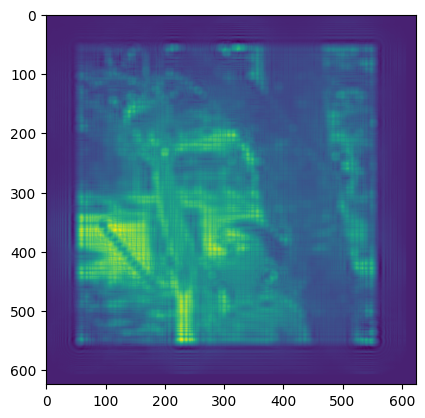

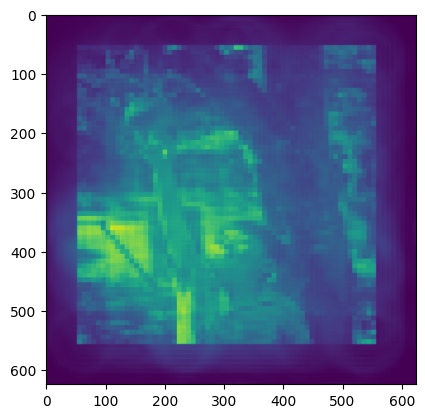

In [16]:
# Tiles : 8x8 ########################################### 
import cupy as cp 
#-------------------------------------- 8x8 Mask
hol8x8 = myDict8[str(depth)]

Margin8X8  = myDict8[str(depth)] #np.zeros([M,N],dtype="complex_")

#----------------------------------------------
indices = np.nonzero(np.abs(Margin8X8))

t1=(np.min(indices[0]))
t2=(np.max(indices[0]))

t3=(np.min(indices[1]))
t4=(np.max(indices[1]))

padded_M  = m + (t2-t1)
padded_N = n + (t4-t3)
#------------------------------------
fixed_shift1 = t2 - t1
fixed_shift2 = t4 - t3
print('---------------- LLL 8x8 ------------------')
s1 = time.time()
#------------------------------------
#crop the non-zero square of Margin8x8
cropped_8X8 = Margin8X8[t1:t2,t3:t4]
#------------------------------------------------------- Multiplication
Temp_gpu = cp.zeros([padded_M,padded_N],dtype='complex64')
LLLb_gpu = cp.array(LLLb)
cropped_8X8_gpu = cp.array(cropped_8X8)
LLLb_flatten_gpu = LLLb_gpu.flatten() 
LLLb_reshaped_gpu = LLLb_flatten_gpu[:, cp.newaxis, cp.newaxis]
broadcasted_view_gpu = cropped_8X8_gpu * LLLb_reshaped_gpu 
#--------------------------------------------------- Additive tiling
for i in range(0,64-1):
    for j in range(0,64-1):
        Temp_gpu[i*8:(fixed_shift1 +i*8)  , j*8:(fixed_shift2+j*8)]  += broadcasted_view_gpu[(i)*64+j,:,:]

s2 = time.time()
print(s2 - s1)
ready_8LLL = cp.asnumpy(Temp_gpu)
rec_8x8 = rec_asm_gray(ready_8LLL, samplingDis_hologram, wlen, rec_dist, zero_pad=0)

plt.imshow(np.real(ready_8LLL)),plt.show()
plt.imshow(rec_8x8),plt.show()
del Temp_gpu
del broadcasted_view_gpu
cp._default_memory_pool.free_all_blocks()


In [17]:
import cupy
mempool = cupy.get_default_memory_pool()

# with cupy.cuda.Device(0):
#     mempool.set_limit(size=1024**3)  # 1 GiB

with cupy.cuda.Device(0):
    mempool.set_limit(size=10*1024**3)  # 2 GiB

time is:  3.1835756301879883


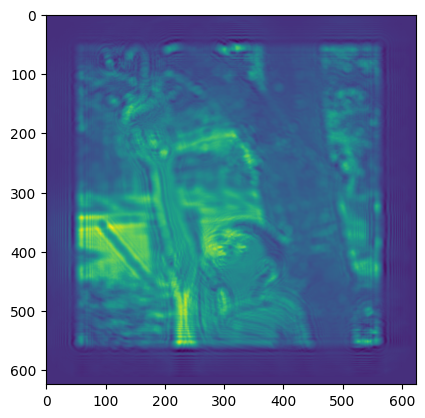

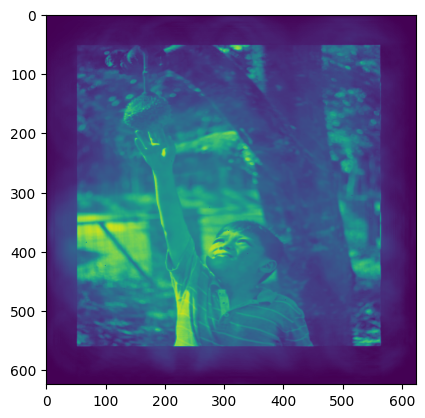

In [18]:
#Full hologram #####################
cp._default_memory_pool.free_all_blocks()
Margin1X1 = myDict1[str(depth)]
indices = np.nonzero(np.abs(Margin1X1))
t1=(np.min(indices[0]))
t2=(np.max(indices[0]))

t3=(np.min(indices[1]))
t4=(np.max(indices[1]))
#------------------------------------
fixed_shift1 = t2 - t1
fixed_shift2 = t4 - t3
cropped_1X1 = Margin1X1[t1:t2,t3:t4]
s1 = time.time()

Temp_gpu = cp.zeros([padded_M,padded_N],dtype='complex64')
Lb_flatten_gpu = cp.array(I.flatten('C'),dtype='complex64')
cropped_1X1_gpu = cp.array(cropped_1X1,dtype='complex64')

#-----------------------------------------------------------
for batch in range(0,(m*n)//10000):
    starts = batch * 10000 
    ends = starts +  10000

    Lb_reshaped_gpu = Lb_flatten_gpu[starts:ends,cp.newaxis,cp.newaxis]
    #print(Lb_reshaped_gpu.shape)
    broadcasted_view_gpu = cropped_1X1_gpu * Lb_reshaped_gpu 
    cnt = 0
    #print('--' , starts,ends)
    for i in range(starts,ends-1):
        row = i//n
        col = i%n
        #print(row,col)
        cnt+=1
        Temp_gpu[row:(fixed_shift1 +row)  , col:(fixed_shift2+col)]  += broadcasted_view_gpu[cnt,:,:]  #row*m+col

#----------------------------------------------------------------
result_sum = cp.asnumpy(Temp_gpu)
rec_full = rec_asm_gray(result_sum, samplingDis_hologram, wlen, rec_dist, zero_pad=0)


s2 = time.time()
print('time is: ',s2-s1)
plt.imshow(np.real(result_sum)),plt.show()
plt.imshow(rec_full),plt.show()
del Temp_gpu
del broadcasted_view_gpu
cp._default_memory_pool.free_all_blocks()

---------------- LL 4x4 ------------------
time is:  0.09367775917053223


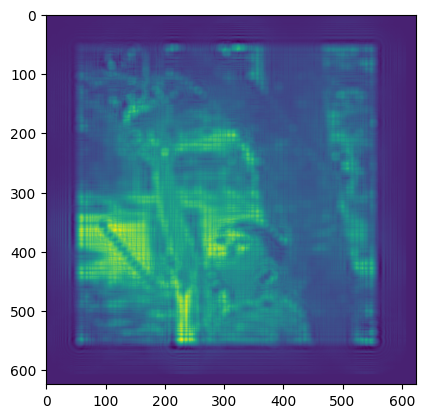

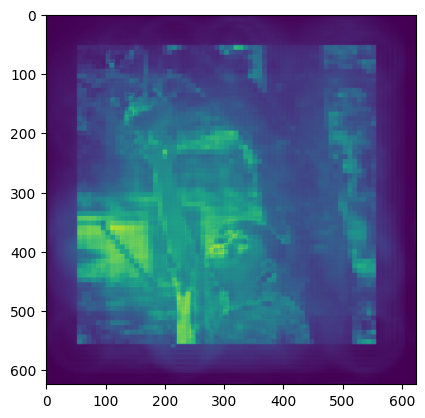

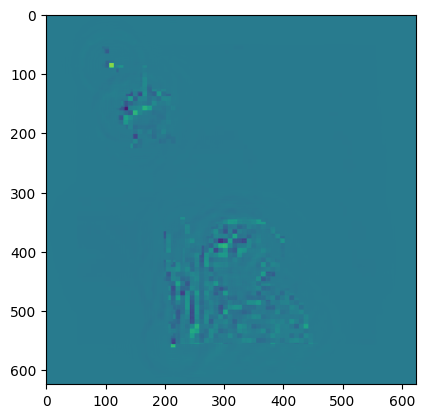

In [22]:
# Tiles : 4x4 #################
import cupy as cp

#################################### 4x4 Mask
print('---------------- LL 4x4 ------------------')
Margin4X4 = myDict4[str(depth)]

#crop the non-zero square of Margin4x4
indices = np.nonzero(np.abs(Margin4X4))

t1=(np.min(indices[0]))
t2=(np.max(indices[0]))

t3=(np.min(indices[1]))
t4=(np.max(indices[1]))

fixed_shift1 = t2 - t1
fixed_shift2 = t4 - t3
cropped_4X4 = Margin4X4[t1:t2,t3:t4]
cropped_4X4 = shift(cropped_4X4 , [-2, -2], cval=0) 
#---------------------------------------------------------------------
s1 = time.time()
new_mask4 = np.zeros([(m), (n)], dtype=np.uint8)
mask[(sal > 0.5) ] = mask[(sal >0.5)]
new_mask4[(sal > 0.5) ] = 1
backup4 = new_mask4
new_mask4 = np.zeros([int(m/4),int(n/4)])
for i in range(1,n, 4):
    for j in range(1,m,4):
        new_mask4[int(i//4), int(j//4)] = np.max(backup4[i:i+4, j:j+4])
nonZeroBlocks_indx = np.argwhere(new_mask4>0)
nonZeroBlocks_indx
#----------------------------------------------- Multiplication on gpu
Temp_gpu = cp.zeros([padded_M,padded_N],dtype='complex64')

LLVb_up = LLVb.repeat(2,axis=0).repeat(2,axis=1)
LLHb_up = LLHb.repeat(2,axis=0).repeat(2,axis=1)
LLDb_up = LLDb.repeat(2,axis=0).repeat(2,axis=1)
diff= (LLVb_up+LLHb_up+LLDb_up)

diff_gpu = cp.array(diff[nonZeroBlocks_indx[:,0],nonZeroBlocks_indx[:,1]],dtype='complex64')
cropped_4X4_gpu = cp.array(cropped_4X4,dtype='complex64')
diff_gpu = diff_gpu.flatten('C')

diff_gpu_reshaped = diff_gpu[:,cp.newaxis,cp.newaxis]
broadcasted_view_gpu = cropped_4X4_gpu * diff_gpu_reshaped 

cnt = 0
for row,col in nonZeroBlocks_indx:
    Temp_gpu[row*4:(fixed_shift1 +row*4)  , col*4:(fixed_shift2+col*4)] += broadcasted_view_gpu[cnt,:,:]  #row*m+col
    cnt+=1
######################### reconstruction LL 4x4 ###############################
s2 = time.time()
print('time is: ',s2-s1)
#----------------------------------------------------------------
diff_L3_L2 = cp.asnumpy(Temp_gpu)
ready_4LL = (diff_L3_L2) + ready_8LLL
rec_4x4 = rec_asm_gray(ready_4LL, samplingDis_hologram, wlen, rec_dist, zero_pad=0)

plt.imshow(np.real(ready_4LL)),plt.show()
plt.imshow(rec_4x4),plt.show()
plt.imshow(rec_4x4 -rec_8x8 ),plt.show()
del Temp_gpu
del broadcasted_view_gpu
cp._default_memory_pool.free_all_blocks()

In [23]:
######################### 2x2 Mask

indices = np.nonzero(np.abs(Margin2X2))

t1=(np.min(indices[0]))
t2=(np.max(indices[0]))

t3=(np.min(indices[1]))
t4=(np.max(indices[1]))
fixed_shift1 = t2 - t1
fixed_shift2 = t4 - t3
cropped_2X2 = Margin2X2[t1:t2,t3:t4]
cropped_2X2 = shift(cropped_2X2 , [-3, -3], cval=0) # 8-2=6 /2
print('---------------------2x2  L ---------------------------')
s1 = time.time()
mask[(sal >0.7)] = mask[(sal >0.7)]
new_mask = np.zeros([m,n], dtype=bool)
new_mask[(sal > 0.7)] = 1 
backup2 = new_mask
new_mask2 = np.zeros([m//2,n//2], dtype=np.uint8)
for i in range(1,n, 2):
    for j in range(1,m,2):
        new_mask2[(i//2),(j//2)] = np.max(backup2[i:i+2, j:j+2])

nonZeroBlocks_indx = np.argwhere(new_mask2>0)

Margin2X2 = np.zeros([M,N],dtype="complex64")
Margin2X2=  myDict2[str(depth)]


#----------------------------------------------- Multiplication on gpu
Temp_gpu = cp.zeros([padded_M,padded_N],dtype='complex64')

LVb_up = LVb.repeat(2, axis=0).repeat(2, axis=1)
LHb_up = LHb.repeat(2, axis=0).repeat(2, axis=1)
LDb_up = LDb.repeat(2, axis=0).repeat(2, axis=1)

diff= (LVb_up+LHb_up+LDb_up)

diff_gpu = cp.array(diff[nonZeroBlocks_indx[:,0],nonZeroBlocks_indx[:,1]],dtype='complex64')
cropped_2X2_gpu = cp.array(cropped_2X2,dtype='complex64')
diff_gpu = diff_gpu.flatten('C')

diff_gpu_reshaped = diff_gpu[:,cp.newaxis,cp.newaxis]
broadcasted_view_gpu = cropped_2X2_gpu * diff_gpu_reshaped 

cnt = 0
for row,col in nonZeroBlocks_indx:
    Temp_gpu[row*2:(fixed_shift1 +row*2)  , col*2:(fixed_shift2+col*2)]+= broadcasted_view_gpu[cnt,:,:]  #row*m+col
    cnt+=1

s2 = time.time()
print('time is', s2-s1)
################################ Recostruction  2x2 + 4x4 + 8x8 #####################
diff_L2_L1 = cp.asnumpy(Temp_gpu)
ready_2L = (diff_L2_L1) + ready_4LL
rec_2x2 = rec_asm_gray(ready_2L, samplingDis_hologram, wlen, rec_dist, zero_pad=0)

plt.imshow(np.real(ready_2L)),plt.show()
plt.imshow(rec_2x2),plt.show()
plt.imshow(rec_2x2 -rec_4x4,cmap='gray'),plt.show()
del Temp_gpu
del broadcasted_view_gpu
cp._default_memory_pool.free_all_blocks()


NameError: name 'Margin2X2' is not defined

In [209]:

# # N = 512
# # d = 200
# # time_wavelet = (N/8 * N/8) +(N/4 * N/4) + (N/2 * N/2)
# # time_pointwise = (N *N)
# # time_fft = N * np.log(N) * d

# # print(time_fft)
# # print(time_pointwise)
# # print(time_wavelet)
# #for the plot

# import numpy as np
# import matplotlib.pyplot as plt

# N = 512
# d_values = np.arange(0, 501)
# time_wavelet_values = (N/8 * N/8) + (N/4 * N/4) + (N/2 * N/2)
# time_pointwise_values = (N * N)
# time_fft_values = N * np.log(N) * d_values

# plt.plot(d_values, time_fft_values, label='FFT: N * log(N) * d')
# plt.plot(d_values, time_pointwise_values*np.ones_like(d_values), label='fully Pointwise: N^2')
# plt.plot(d_values, time_wavelet_values*np.ones_like(d_values), label='final stage of Wavelet: (N/8 * N/8) + (N/4 * N/4) + (N/2 * N/2)')
# plt.xlabel('depths')
# plt.ylabel('Time (arbitrary units)')
# plt.legend()
# plt.show()


------------------ L 1x1 ---------------------
time is 0.440535306930542
---------------- I ---------------------


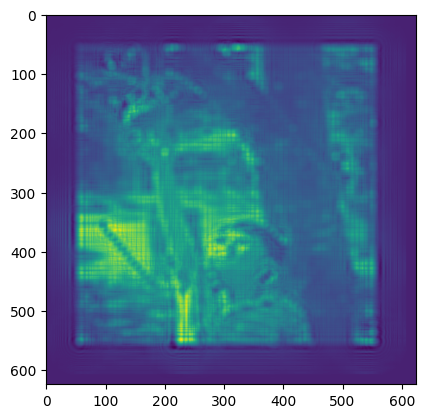

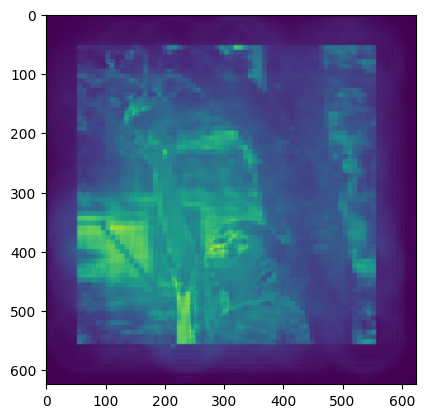

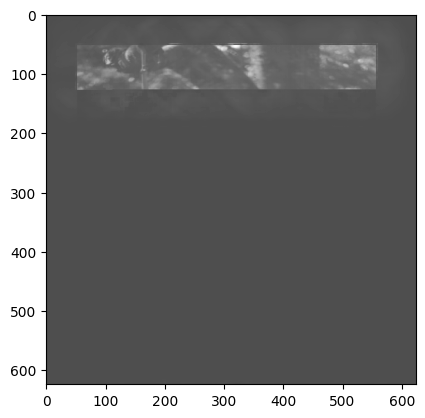

In [274]:
#Tiles : 1x1 ########################################### 
indices = np.nonzero(np.abs(Margin1X1))
t1=(np.min(indices[0]))
t2=(np.max(indices[0]))

t3=(np.min(indices[1]))
t4=(np.max(indices[1]))
fixed_shift1 = t2 - t1
fixed_shift2 = t4 - t3
cropped_1X1 = Margin1X1[t1:t2,t3:t4]
cropped_1X1 = shift(cropped_1X1 , [-3.5, -3.5], cval=0) # 8 - 1 = 7 / 2

############# 1x1 Mask
print('------------------ L 1x1 ---------------------')
s1 = time.time() ##### time starts
mask = np.zeros([(m), (n)], dtype=np.uint8)
new_mask1 = np.zeros([(m), (n)], dtype=np.uint8)
color_backup = I
color_backup = color_backup/255
mask[sal > 0.9] = 1
new_mask1[sal > 0.9] = 1

nonZeroBlocks_indx = np.argwhere(new_mask1>0)
#print(nonZeroBlocks_indx.shape)
Margin1X1 =  myDict1[str(depth)]

#################################################
Temp_gpu = cp.zeros([padded_M,padded_N],dtype='complex64')
Vb_up = Vb.repeat(2, axis=0).repeat(2, axis=1)
Hb_up = Hb.repeat(2, axis=0).repeat(2, axis=1)
Db_up = Db.repeat(2, axis=0).repeat(2, axis=1)
diff= (Vb_up+Hb_up+Db_up)

#diff_L2_L1 = diff

diff_gpu = cp.array(diff[nonZeroBlocks_indx[:,0],nonZeroBlocks_indx[:,1]],dtype='complex64')
cropped_1X1_gpu = cp.array(cropped_1X1,dtype='complex64')
diff_gpu = diff_gpu.flatten('C')

diff_gpu_reshaped = diff_gpu[:,cp.newaxis,cp.newaxis]
#broadcasted_view_gpu = cropped_1X1_gpu * diff_gpu_reshaped 
step = 10000
for batch in range(0,(nonZeroBlocks_indx.shape[0])//step):
    starts = batch * step 
    ends = starts +  step

    Lb_reshaped_gpu = Lb_flatten_gpu[starts:ends,cp.newaxis,cp.newaxis]
    #print(Lb_reshaped_gpu.shape)
    broadcasted_view_gpu = cropped_1X1_gpu * Lb_reshaped_gpu 
    cnt = 0
    #print('--' , starts,ends)
    for i in range(starts,ends-1):
        row = i//n
        col = i%n
        #print(row,col)
        cnt+=1
        Temp_gpu[row:(fixed_shift1 +row)  , col:(fixed_shift2+col)]  += broadcasted_view_gpu[cnt,:,:]  #row*m+col

s2 = time.time()
print('time is', s2-s1)
################################ Recostruction  1x1 + 2x2 + 4x4 + 8x8 #####################
print('---------------- I ---------------------')

diff_L1_I = cp.asnumpy(Temp_gpu)
ready_I = (diff_L1_I) + ready_2L
rec_1x1 = rec_asm_gray(ready_I, samplingDis_hologram, wlen, rec_dist, zero_pad=0)

plt.imshow(np.real(ready_I)),plt.show()
plt.imshow(rec_1x1),plt.show()
plt.imshow(rec_1x1 -rec_2x2,cmap='gray'),plt.show()
del Temp_gpu
del broadcasted_view_gpu
cp._default_memory_pool.free_all_blocks()
# ssim_value1, psnr_value1  = accuracy(rec_8LLL,rec_full);print(ssim_value1);print(psnr_value1)
# ssim_value2, psnr_value2  = accuracy(rec_4LL,rec_full);print(ssim_value2);print(psnr_value2)
# ssim_value3, psnr_value3  = accuracy(rec_2L,rec_full);print(ssim_value3);print(psnr_value3)
# ssim_value4, psnr_value4  = accuracy(rec_I,rec_full);print(ssim_value4);print(psnr_value4)



# plt.hist(I, label='series2', alpha=0.7, edgecolor='red')
# # plt.hist(rec_4LL *256, label='series1', alpha=.7, edgecolor='red')
# # plt.hist(rec_hol_L *256, label='series1', alpha=.7, edgecolor='blue')
# plt.hist(rec_full * 255, label='series1', alpha=.7, edgecolor='green')
# plt.show()
# plt.imshow(rec_full * 255 - I)


# ------------------ L 1x1 ---------------------
# ---------------- I ---------------------
# Third level 2788.3075085
# plt.imshow(rec_8LLL,cmap='gray'), plt.title('rec LLL 8x8'), plt.show()
# plt.imshow(rec_4LL,cmap='gray'), plt.title('rec LL 4x4'), plt.show()
# plt.imshow(rec_2L,cmap='gray'), plt.title('rec L 2x2'), plt.show()
# plt.imshow(rec_I,cmap='gray'), plt.title('rec I 1x1'), plt.show()

In [211]:
# import cupy as cp
# import time

# Temp_gpu = cp.zeros([624,624],dtype='complex128')

# s1 = time.time()
# quantized_64x64_gpu = cp.array(quantized_64x64)
# cropped_8X8_gpu = cp.array(cropped_8X8)

# LLLb_flatten_gpu = quantized_64x64_gpu.flatten() 
# LLLb_reshaped_gpu = LLLb_flatten_gpu[:, cp.newaxis, cp.newaxis]
# print(cropped_8X8_gpu.shape , LLLb_reshaped_gpu.shape )

# broadcasted_view_gpu = cropped_8X8_gpu * LLLb_reshaped_gpu 
# print(broadcasted_view_gpu.shape)
# unflattened_array = broadcasted_view_gpu.reshape([64,64,112,112])
# print(unflattened_array.shape)
# cnt = 0 
# rows = np.arange(0, 64)[:, np.newaxis]  # Column vector
# cols = np.arange(0, 64)  # Row vector

# for i in range(0,64-1):
#     for j in range(0,64-1):
#         Temp_gpu[i*8:(fixed_shift1 +i*8)  , j*8:(fixed_shift2+j*8)]  += broadcasted_view_gpu[(i)*64+j,:,:]
#         cnt +=1

# s2 = time.time()
# print(s2 - s1)
# result_sum = cp.asnumpy(Temp_gpu)
# rec_8LLL = rec_asm_gray(result_sum, samplingDis_hologram, wlen, rec_dist, zero_pad=0)

# plt.imshow(np.real(result_sum)),plt.show()
# plt.imshow(rec_8LLL),plt.show()